## Diverse Dermatology Images Dataset

DDI dataset for skin cancer lesion classification.

Diverse Dermatology Images (DDI) dataset—the first publicly available, deeply curated, and pathologically confirmed image dataset with diverse skin tones.

Dataset link:
https://stanfordaimi.azurewebsites.net/datasets/35866158-8196-48d8-87bf-50dca81df965
Dataset access request is required. 

- For research purpose only!

*** There are 656 images representing 570 unique patients. Each image label was expertly curated: skin tone was labeled based on in-person evaluation at the clinic visit cross-referenced against demographic photos and review of the clinical images by two board certified dermatologists. Each diagnosis was based on pathology reports from biopsy: these reports and the corresponding image was reviewed by a board certified dermatologist and dermatopathologist.***

In [41]:
import os
import sys
import glob

import numpy as np
import pandas as pd
from scipy import stats
from scipy import ndimage
import skimage.io

import torch
import torch.nn as nn
import timm
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, random_split
import torchvision
from torchvision import models, transforms
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
from torchvision.models import MobileNet_V2_Weights
from torchvision.models import (VGG16_Weights, ResNet50_Weights, Inception_V3_Weights,
                                inception_v3, mobilenet_v2, MobileNet_V2_Weights)
from torchvision.models import alexnet, AlexNet_Weights
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             confusion_matrix, roc_auc_score, roc_curve)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve

from PIL import Image
import cv2 as cv
import copy 
from tensorflow.keras import datasets, layers, models
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
%matplotlib inline

In [2]:
ddi_df = pd.read_csv('ddi_metadata.csv',index_col=0)
ddi_df.head()

,DDI_ID,DDI_file,skin_tone,malignant,disease
0,1,000001.png,56,True,melanoma-in-situ
1,2,000002.png,56,True,melanoma-in-situ
2,3,000003.png,56,True,mycosis-fungoides
3,4,000004.png,56,True,squamous-cell-carcinoma-in-situ
4,5,000005.png,12,True,basal-cell-carcinoma


In [3]:
ddi_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 656 entries, 0 to 655
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   DDI_ID     656 non-null    int64 
 1   DDI_file   656 non-null    object
 2   skin_tone  656 non-null    int64 
 3   malignant  656 non-null    bool  
 4   disease    656 non-null    object
dtypes: bool(1), int64(2), object(2)
memory usage: 26.3+ KB


In [4]:
ddi_df['DDI_file'].count()

656

In [5]:
ddi_df['disease'].value_counts()

disease
melanocytic-nevi             119
seborrheic-keratosis          58
verruca-vulgaris              50
basal-cell-carcinoma          41
epidermal-cyst                35
                            ... 
keloid                         1
angioleiomyoma                 1
lymphocytic-infiltrations      1
wart                           1
acral-melanotic-macule         1
Name: count, Length: 78, dtype: int64

In [6]:
ddi_df.describe()

,DDI_ID,skin_tone
count,656.000000,656.000000
mean,328.500000,33.966463
std,189.515171,17.511578
min,1.000000,12.000000
25%,164.750000,12.000000
50%,328.500000,34.000000
75%,492.250000,56.000000
max,656.000000,56.000000


In [7]:
ddi_df.isnull().sum()

DDI_ID       0
DDI_file     0
skin_tone    0
malignant    0
disease      0
dtype: int64

**No missing values in the dataset**

In [8]:
ddi_df['disease'].unique()

array(['melanoma-in-situ', 'mycosis-fungoides',
       'squamous-cell-carcinoma-in-situ', 'basal-cell-carcinoma',
       'squamous-cell-carcinoma', 'melanoma-acral-lentiginous',
       'basal-cell-carcinoma-superficial',
       'squamous-cell-carcinoma-keratoacanthoma',
       'subcutaneous-t-cell-lymphoma', 'melanocytic-nevi',
       'seborrheic-keratosis-irritated', 'focal-acral-hyperkeratosis',
       'hyperpigmentation', 'lipoma', 'foreign-body-granuloma',
       'blue-nevus', 'verruca-vulgaris', 'acrochordon', 'wart',
       'abrasions-ulcerations-and-physical-injuries',
       'basal-cell-carcinoma-nodular', 'epidermal-cyst',
       'acquired-digital-fibrokeratoma', 'epidermal-nevus',
       'seborrheic-keratosis', 'trichilemmoma', 'pyogenic-granuloma',
       'neurofibroma', 'syringocystadenoma-papilliferum',
       'nevus-lipomatosus-superficialis', 'benign-keratosis',
       'inverted-follicular-keratosis', 'onychomycosis', 'dermatofibroma',
       'trichofolliculoma', 'lympho

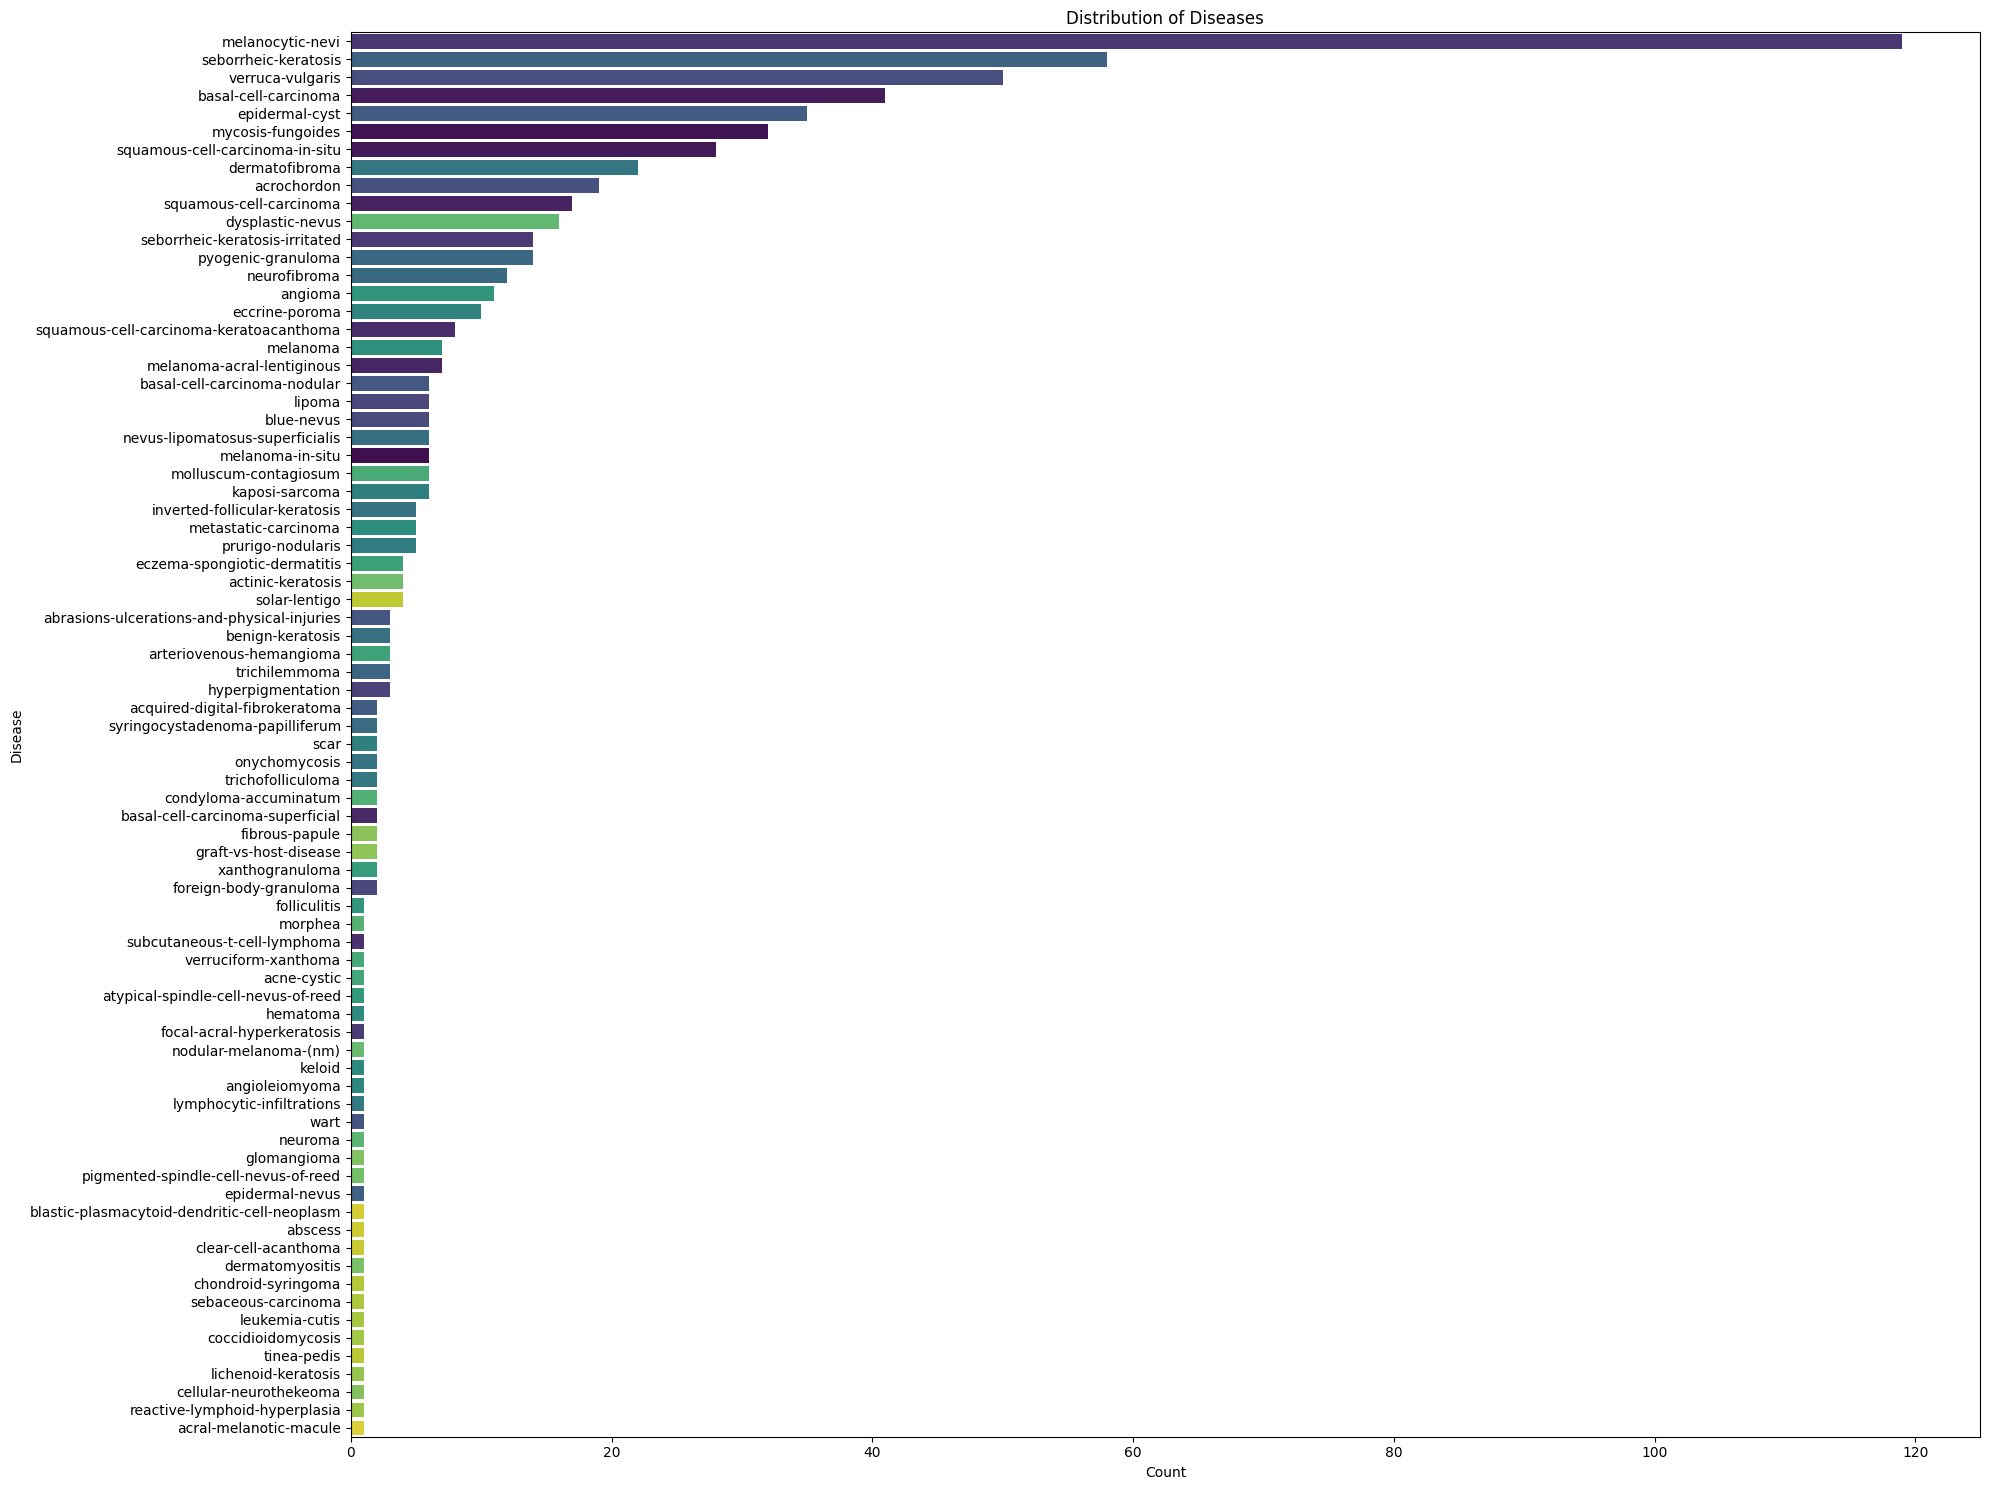

In [9]:
# Plotting 'Distribution of Diseases'
fig, ax = plt.subplots(figsize=(20, 15))
disease_counts = ddi_df['disease'].value_counts().sort_values(ascending=False)
sns.countplot(y='disease', data=ddi_df, ax=ax, palette='viridis', order=disease_counts.index, hue='disease', legend=False)

ax.set_title('Distribution of Diseases')
ax.set_xlabel('Count')
ax.set_ylabel('Disease')
plt.tight_layout()
plt.show()

#### Fitzpatrick skin types labels in the dataset: FST 12 - Fitzpatrick I-II, FST 34 - Fitzpatrick III-IV, FST 56 - Fitzpatrick V-VI

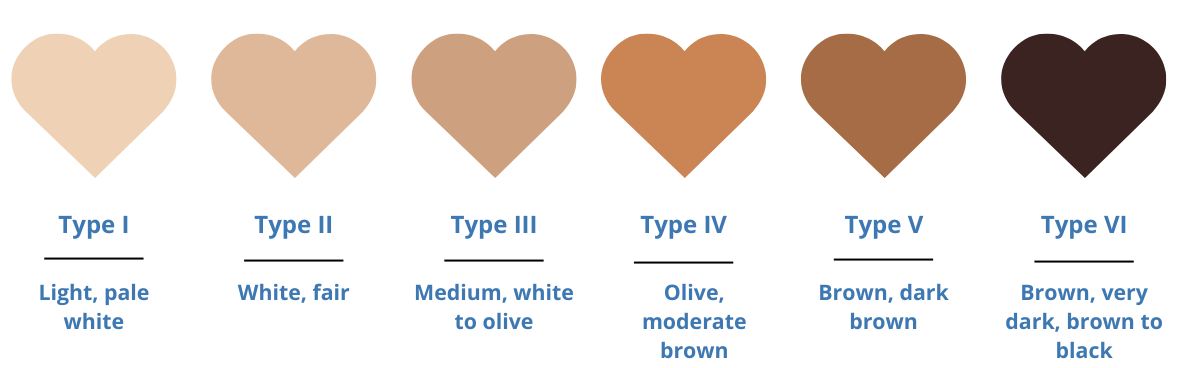

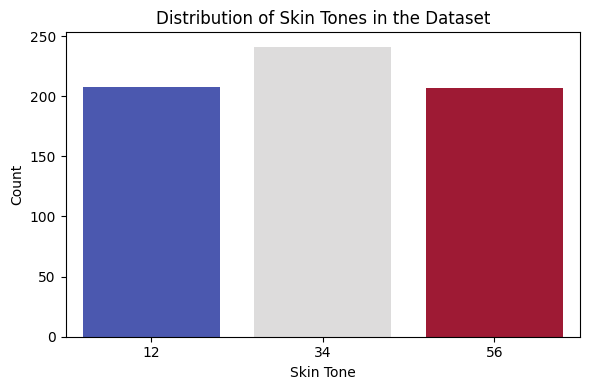

In [10]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(x='skin_tone', data=ddi_df, hue='skin_tone', ax=ax, palette='coolwarm', legend=False)

# Set the title and labels
ax.set_title('Distribution of Skin Tones in the Dataset')
ax.set_xlabel('Skin Tone')
ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

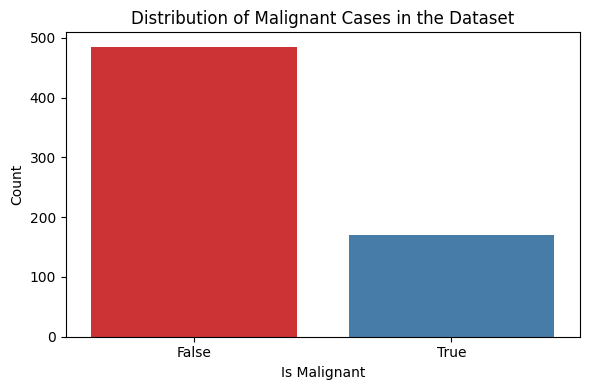

In [11]:
#Distribution of data in 'malignant' column
fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(x='malignant', data=ddi_df, hue='malignant', ax=ax, palette='Set1', legend=False)
ax.set_title('Distribution of Malignant Cases in the Dataset')
ax.set_xlabel('Is Malignant')
ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

In [12]:
ddi_images = glob.glob('*.png')
len(ddi_images)

656

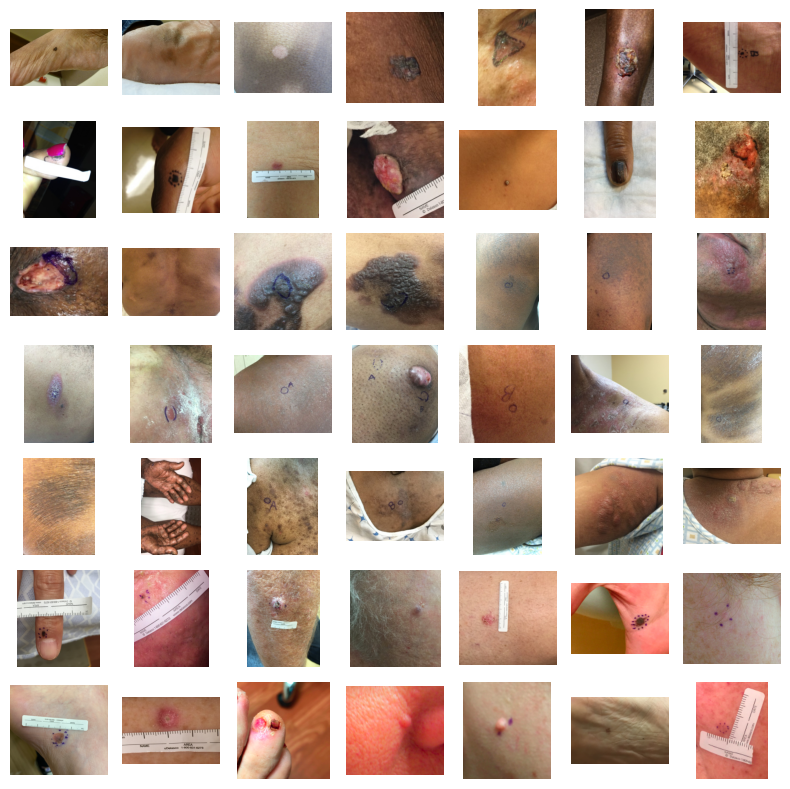

In [13]:
plt.figure(figsize=(8, 8))
nrows, ncols = 7, 7
max_imgs = nrows * ncols  # Maximum number of images you can display

# Only loop through the first 'max_imgs' images
for i, file in enumerate(ddi_images[:max_imgs]):
    img = skimage.io.imread(file)

    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()

### Step 1: Define a Custom Dataset Class
This class will handle loading and transforming images on-the-fly.

In [14]:
class CustomDDIDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.ddi_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.ddi_frame['malignant'] = self.ddi_frame['malignant'].astype(int)

    def __len__(self):
        return len(self.ddi_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.ddi_frame.iloc[idx]['DDI_file'])
        image = Image.open(img_name).convert('RGB')
        label = self.ddi_frame.iloc[idx]['malignant']
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label, dtype=torch.long)
        return image, label

### Step 2: Initialize Dataset and DataLoader

In [15]:
# Transformation with data augmentation for training
train_transform = T.Compose([

    T.Resize(299),  # Resize so the smallest side is 299 pixels
    T.RandomHorizontalFlip(),  # Randomly flip images horizontally
    T.RandomRotation(10),  # Randomly rotate images by up to 10 degrees
    T.RandomResizedCrop(299),  # Randomly crop and resize to 299x299
    T.ToTensor(),  # Convert image to a PyTorch tensor
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Transformation without data augmentation for validation/testing
val_transform = T.Compose([
  
    T.Resize(299),
    T.CenterCrop(299),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize the full dataset with transformations
full_dataset = CustomDDIDataset(csv_file='C:\\Users\\user\\DDI\\ddi_metadata.csv',
                                root_dir='C:\\Users\\user\\DDI\\images',
                                transform=train_transform)  # You might want to have a separate transform for full_dataset if necessary

# For training
train_dataset = CustomDDIDataset(csv_file='C:\\Users\\user\\DDI\\ddi_metadata.csv',
                                 root_dir='C:\\Users\\user\\DDI\\images',
                                 transform=train_transform)

# For validation/testing
val_dataset = CustomDDIDataset(csv_file='C:\\Users\\user\\DDI\\ddi_metadata.csv',
                               root_dir='C:\\Users\\user\\DDI\\images',
                               transform=val_transform)

### Step 3 Split Your Dataset into Training, Validating and Testing

In [16]:
# Splitting the dataset into training, validation, and test sets
train_idx, val_test_idx = train_test_split(range(len(full_dataset)), test_size=0.4, random_state=42)
val_idx, test_idx = train_test_split(val_test_idx, test_size=0.5, random_state=42)

# Creating train, validation, and test subsets
train_subset = Subset(full_dataset, train_idx)
val_subset = Subset(full_dataset, val_idx)
test_subset = Subset(full_dataset, test_idx)

# Creating DataLoader instances for all subsets
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

### Step 4: Define the Training Loop

In [17]:
def train_model(model, criterion, optimizer, scheduler, train_dataloader, val_dataloader, num_epochs=30, patience=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0
        
        # Training phase
        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()  # Zero the parameter gradients
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        train_loss = running_loss / len(train_dataloader.dataset)
        train_acc = running_corrects.double() / len(train_dataloader.dataset)
        
        # Validation phase
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        val_corrects = 0
        
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
        
        val_loss = val_loss / len(val_dataloader.dataset)
        val_acc = val_corrects.double() / len(val_dataloader.dataset)
        
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
        print(f'Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        
        # Checkpointing
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
            print('Validation loss decreased, saving model...')
        else:
            epochs_no_improve += 1
            print(f'Validation loss did not decrease, epochs with no improvement: {epochs_no_improve}.')
        
        if epochs_no_improve == patience:
            print('Early stopping triggered.')
            break
        
        scheduler.step()

    print('Training complete. Best val Loss: {:4f}'.format(best_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

#### Now we will test different models for training

#### MobileNetV2 model

In [18]:
from torchvision import models
# Initialize the MobileNetV2 model with pre-trained weights
mobilenet_v2_model = models.mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)

# Modifying the classifier for binary classification
num_ftrs = mobilenet_v2_model.classifier[1].in_features
mobilenet_v2_model.classifier[1] = nn.Linear(num_ftrs, 2)

# Define the device and move the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet_v2_model = mobilenet_v2_model.to(device)

# Setup the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet_v2_model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Call the updated train_model function with train and validation dataloaders
MobileNetV2_best_model = train_model(mobilenet_v2_model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=30, patience=5)

Epoch 1/30
Train Loss: 0.5748 Acc: 0.7150
Validation Loss: 0.6605 Acc: 0.7176
Validation loss decreased, saving model...
Epoch 2/30
Train Loss: 0.4685 Acc: 0.7786
Validation Loss: 0.6412 Acc: 0.7328
Validation loss decreased, saving model...
Epoch 3/30
Train Loss: 0.4638 Acc: 0.7939
Validation Loss: 0.4835 Acc: 0.7863
Validation loss decreased, saving model...
Epoch 4/30
Train Loss: 0.4039 Acc: 0.8168
Validation Loss: 0.5271 Acc: 0.7710
Validation loss did not decrease, epochs with no improvement: 1.
Epoch 5/30
Train Loss: 0.3841 Acc: 0.8473
Validation Loss: 0.5744 Acc: 0.7405
Validation loss did not decrease, epochs with no improvement: 2.
Epoch 6/30
Train Loss: 0.3317 Acc: 0.8651
Validation Loss: 0.5514 Acc: 0.7557
Validation loss did not decrease, epochs with no improvement: 3.
Epoch 7/30
Train Loss: 0.2721 Acc: 0.9109
Validation Loss: 0.5094 Acc: 0.7710
Validation loss did not decrease, epochs with no improvement: 4.
Epoch 8/30
Train Loss: 0.2773 Acc: 0.8931
Validation Loss: 0.5584

### Let's evaluate the model performance

Accuracy: 0.7955
Precision: 0.6875
Recall: 0.3333
F1 Score: 0.4490
ROC AUC Score: 0.7215
Confusion Matrix:
 [[94  5]
 [22 11]]


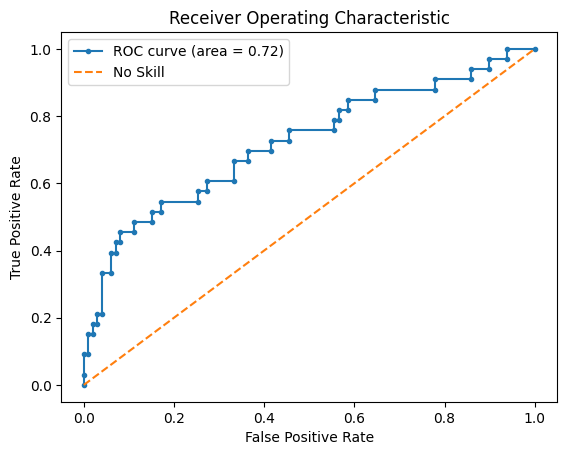

In [19]:
def evaluate_model(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    true_labels = []
    predictions = []
    pred_probs = []  # Store prediction probabilities for ROC AUC calculation
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            # Assuming the model outputs logit scores, apply softmax to get probabilities
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # Get the probability of the positive class
            
            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())
            pred_probs.extend(probs)  # Append probability of positive class
    
    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    auc_score = roc_auc_score(true_labels, pred_probs)  # Calculate ROC AUC score
    conf_matrix = confusion_matrix(true_labels, predictions)
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC Score: {auc_score:.4f}')
    print('Confusion Matrix:\n', conf_matrix)
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(true_labels, pred_probs)
    plt.plot(fpr, tpr, marker='.', label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend()
    plt.show()

# Assuming your best_model is defined and test_dataloader is your validation/test dataloader
evaluate_model(MobileNetV2_best_model, test_loader, device)

### ResNet50 model

In [20]:
# Load the pre-trained ResNet50 model
resnet50_model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# Modify the final fully connected layer for binary classification
num_ftrs_resnet50 = resnet50_model.fc.in_features
resnet50_model.fc = nn.Linear(num_ftrs_resnet50, 2)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device
resnet50_model = resnet50_model.to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(resnet50_model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Train the model
# Call the updated train_model function with train and validation dataloaders
ResNet50_best_model = train_model(resnet50_model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=30, patience=5)

Epoch 1/30
Train Loss: 0.5903 Acc: 0.6743
Validation Loss: 0.5770 Acc: 0.7252
Validation loss decreased, saving model...
Epoch 2/30
Train Loss: 0.4593 Acc: 0.8117
Validation Loss: 0.5664 Acc: 0.7786
Validation loss decreased, saving model...
Epoch 3/30
Train Loss: 0.3917 Acc: 0.8346
Validation Loss: 0.6741 Acc: 0.7481
Validation loss did not decrease, epochs with no improvement: 1.
Epoch 4/30
Train Loss: 0.3598 Acc: 0.8601
Validation Loss: 0.5253 Acc: 0.8015
Validation loss decreased, saving model...
Epoch 5/30
Train Loss: 0.2711 Acc: 0.8728
Validation Loss: 0.5548 Acc: 0.7634
Validation loss did not decrease, epochs with no improvement: 1.
Epoch 6/30
Train Loss: 0.2680 Acc: 0.8830
Validation Loss: 0.5888 Acc: 0.7557
Validation loss did not decrease, epochs with no improvement: 2.
Epoch 7/30
Train Loss: 0.2613 Acc: 0.8804
Validation Loss: 0.5295 Acc: 0.8092
Validation loss did not decrease, epochs with no improvement: 3.
Epoch 8/30
Train Loss: 0.2304 Acc: 0.8906
Validation Loss: 0.5896

Accuracy: 0.7803
Precision: 0.5909
Recall: 0.3939
F1 Score: 0.4727
ROC AUC Score: 0.7542
Confusion Matrix:
 [[90  9]
 [20 13]]


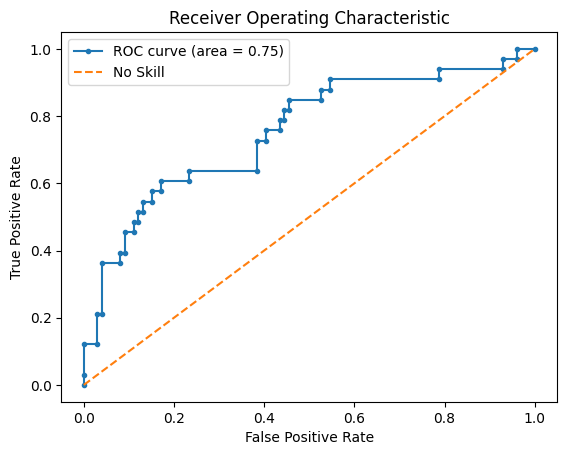

In [21]:
evaluate_model(ResNet50_best_model, test_loader, device)

### Inception3 model

In [22]:
# Load the pre-trained InceptionV3 model
inceptionv3_model = inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1, aux_logits=True)

# Modify the final fully connected layer for binary classification
num_ftrs_inceptionv3 = inceptionv3_model.fc.in_features
inceptionv3_model.fc = nn.Linear(num_ftrs_inceptionv3, 2)

# Also modify the auxillary network's fully connected layer
num_ftrs_aux_inceptionv3 = inceptionv3_model.AuxLogits.fc.in_features
inceptionv3_model.AuxLogits.fc = nn.Linear(num_ftrs_aux_inceptionv3, 2)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device
inceptionv3_model = inceptionv3_model.to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(inceptionv3_model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

For the InceptionV3 model, we need to adjust the train_model function to account for the auxiliary output during the training phase. The auxiliary output is only used during training and should not be considered during evaluation.

In [23]:
def train_model_1(model, criterion, optimizer, scheduler, train_dataloader, val_dataloader, num_epochs=30, patience=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0
        
        # Training phase
        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()  # Zero the parameter gradients
            
            # Handle the outputs from the Inception model (main and aux outputs)
            if hasattr(model, 'aux_logits') and model.aux_logits:
                outputs, aux_outputs = model(inputs)
                loss1 = criterion(outputs, labels)
                loss2 = criterion(aux_outputs, labels)
                loss = loss1 + 0.4*loss2  # Combine losses with auxiliary loss weighted
            else:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()
            
            # Since we possibly have two losses, take the main loss for running loss
            running_loss += loss1.item() * inputs.size(0) if hasattr(model, 'aux_logits') and model.aux_logits else loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        train_loss = running_loss / len(train_dataloader.dataset)
        train_acc = running_corrects.double() / len(train_dataloader.dataset)
        
        # Validation phase
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        val_corrects = 0
        
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
        
        val_loss = val_loss / len(val_dataloader.dataset)
        val_acc = val_corrects.double() / len(val_dataloader.dataset)
        
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
        print(f'Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        
        # Checkpointing
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
            print('Validation loss decreased, saving model...')
        else:
            epochs_no_improve += 1
            print(f'Validation loss did not decrease, epochs with no improvement: {epochs_no_improve}.')
        
        if epochs_no_improve == patience:
            print('Early stopping triggered.')
            break
        
        scheduler.step()  # Adjust the learning rate based on the number of epochs

    print('Training complete. Best val Loss: {:4f}'.format(best_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [24]:
# Call the updated train_model function with train and validation dataloaders
inceptionv3_best_model = train_model_1(inceptionv3_model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=30, patience=5)

Epoch 1/30
Train Loss: 0.6131 Acc: 0.6692
Validation Loss: 0.5941 Acc: 0.7176
Validation loss decreased, saving model...
Epoch 2/30
Train Loss: 0.4736 Acc: 0.7888
Validation Loss: 0.5460 Acc: 0.7023
Validation loss decreased, saving model...
Epoch 3/30
Train Loss: 0.4137 Acc: 0.8193
Validation Loss: 0.5797 Acc: 0.7252
Validation loss did not decrease, epochs with no improvement: 1.
Epoch 4/30
Train Loss: 0.3762 Acc: 0.8321
Validation Loss: 0.6630 Acc: 0.7328
Validation loss did not decrease, epochs with no improvement: 2.
Epoch 5/30
Train Loss: 0.3183 Acc: 0.8753
Validation Loss: 0.5658 Acc: 0.7481
Validation loss did not decrease, epochs with no improvement: 3.
Epoch 6/30
Train Loss: 0.2912 Acc: 0.8830
Validation Loss: 0.5330 Acc: 0.7786
Validation loss decreased, saving model...
Epoch 7/30
Train Loss: 0.2168 Acc: 0.9338
Validation Loss: 0.5744 Acc: 0.7863
Validation loss did not decrease, epochs with no improvement: 1.
Epoch 8/30
Train Loss: 0.1883 Acc: 0.9415
Validation Loss: 0.5396

Accuracy: 0.7652
Precision: 0.5417
Recall: 0.3939
F1 Score: 0.4561
ROC AUC Score: 0.7502
Confusion Matrix:
 [[88 11]
 [20 13]]


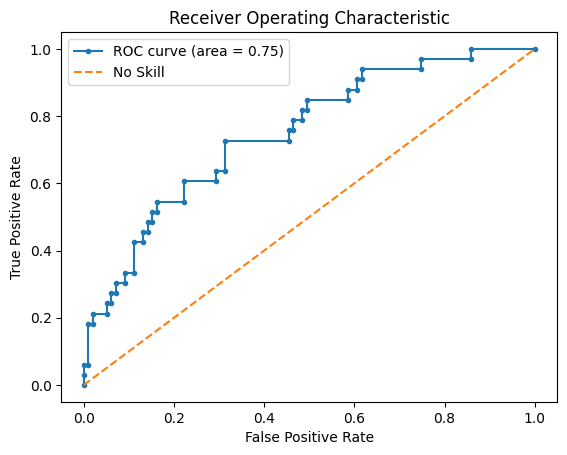

In [25]:
# Assuming your best_model is defined and test_dataloader is your validation/test dataloader
evaluate_model(inceptionv3_best_model, test_loader, device)

## VGG16 model

In [32]:
vgg16_model = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
num_ftrs_vgg16 = vgg16_model.classifier[6].in_features
vgg16_model.classifier[6] = nn.Linear(num_ftrs_vgg16, 2)  # For binary classification

In [33]:
# Move the model to the device
vgg16_model = vgg16_model.to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(vgg16_model.parameters(), lr=0.0001)

# Optionally define a learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
# Assuming train_loader and val_loader are already defined
VGG16_best_model = train_model(vgg16_model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=30, patience=5)

Epoch 1/30
Train Loss: 0.6182 Acc: 0.7226
Validation Loss: 0.5929 Acc: 0.7176
Validation loss decreased, saving model...
Epoch 2/30
Train Loss: 0.5887 Acc: 0.7074
Validation Loss: 0.6838 Acc: 0.7176
Validation loss did not decrease, epochs with no improvement: 1.
Epoch 3/30
Train Loss: 0.5836 Acc: 0.7430
Validation Loss: 0.5882 Acc: 0.7176
Validation loss decreased, saving model...
Epoch 4/30
Train Loss: 0.5086 Acc: 0.7455
Validation Loss: 0.6217 Acc: 0.7176
Validation loss did not decrease, epochs with no improvement: 1.
Epoch 5/30
Train Loss: 0.5024 Acc: 0.7405
Validation Loss: 0.5653 Acc: 0.7557
Validation loss decreased, saving model...
Epoch 6/30
Train Loss: 0.5519 Acc: 0.7150
Validation Loss: 0.6779 Acc: 0.7176
Validation loss did not decrease, epochs with no improvement: 1.
Epoch 7/30
Train Loss: 0.5063 Acc: 0.7455
Validation Loss: 0.5842 Acc: 0.7252
Validation loss did not decrease, epochs with no improvement: 2.
Epoch 8/30
Train Loss: 0.4852 Acc: 0.7532
Validation Loss: 0.6364

Accuracy: 0.7879
Precision: 0.7273
Recall: 0.2424
F1 Score: 0.3636
ROC AUC Score: 0.7092
Confusion Matrix:
 [[96  3]
 [25  8]]


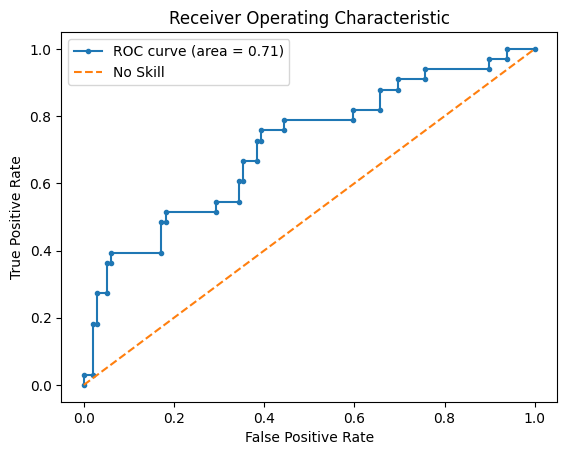

In [34]:
evaluate_model(VGG16_best_model, test_loader, device)

## MobileNet_V3_Large_Weights

In [35]:
# Initialize the MobileNetV3-Large model with pre-trained weights
mobilenet_v3_large_model = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1)

# Modifying the classifier for binary classification
# MobileNetV3-Large uses 'classifier' instead of 'fc' for its final fully connected layer
num_ftrs = mobilenet_v3_large_model.classifier[-1].in_features
mobilenet_v3_large_model.classifier[-1] = nn.Linear(num_ftrs, 2)

# Define the device and move the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet_v3_large_model = mobilenet_v3_large_model.to(device)

# Setup the loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet_v3_large_model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Assuming train_model function, train_loader, and val_loader are defined as per your earlier code
MobileNetV3_best_model = train_model(mobilenet_v3_large_model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=30, patience=5)

Epoch 1/30
Train Loss: 0.6011 Acc: 0.6794
Validation Loss: 0.6293 Acc: 0.6870
Validation loss decreased, saving model...
Epoch 2/30
Train Loss: 0.4972 Acc: 0.7557
Validation Loss: 0.6041 Acc: 0.7328
Validation loss decreased, saving model...
Epoch 3/30
Train Loss: 0.4648 Acc: 0.7710
Validation Loss: 0.5903 Acc: 0.7252
Validation loss decreased, saving model...
Epoch 4/30
Train Loss: 0.4254 Acc: 0.8168
Validation Loss: 0.5933 Acc: 0.7252
Validation loss did not decrease, epochs with no improvement: 1.
Epoch 5/30
Train Loss: 0.4168 Acc: 0.8372
Validation Loss: 0.5704 Acc: 0.7176
Validation loss decreased, saving model...
Epoch 6/30
Train Loss: 0.3580 Acc: 0.8372
Validation Loss: 0.6186 Acc: 0.7176
Validation loss did not decrease, epochs with no improvement: 1.
Epoch 7/30
Train Loss: 0.3215 Acc: 0.8651
Validation Loss: 0.6190 Acc: 0.7176
Validation loss did not decrease, epochs with no improvement: 2.
Epoch 8/30
Train Loss: 0.2988 Acc: 0.8779
Validation Loss: 0.5647 Acc: 0.7405
Validatio

Accuracy: 0.7652
Precision: 0.6000
Recall: 0.1818
F1 Score: 0.2791
ROC AUC Score: 0.6838
Confusion Matrix:
 [[95  4]
 [27  6]]


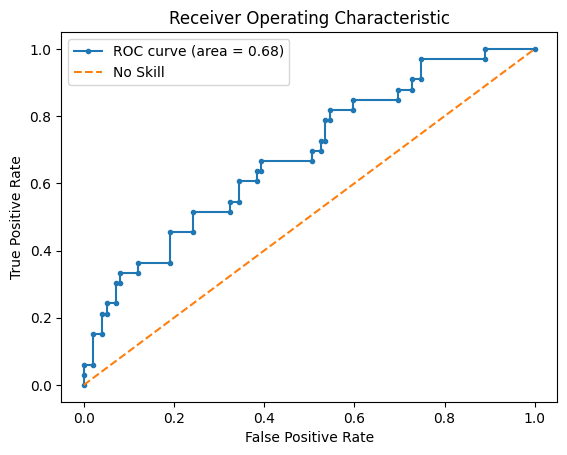

In [36]:
evaluate_model(MobileNetV3_best_model, test_loader, device)

## Xception model

In [37]:
# Create the Xception model with pre-trained weights using the updated model name
xception_model = timm.create_model('legacy_xception', pretrained=True)

# Modify the classifier for binary classification
num_ftrs = xception_model.fc.in_features
xception_model.fc = nn.Linear(num_ftrs, 2)

# Define the device and move the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xception_model = xception_model.to(device)

# Setup the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(xception_model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Xception_best_model = train_model(xception_model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=30, patience=5)

Epoch 1/30
Train Loss: 0.5792 Acc: 0.7379
Validation Loss: 0.5614 Acc: 0.7176
Validation loss decreased, saving model...
Epoch 2/30
Train Loss: 0.4945 Acc: 0.7557
Validation Loss: 0.5810 Acc: 0.7328
Validation loss did not decrease, epochs with no improvement: 1.
Epoch 3/30
Train Loss: 0.4125 Acc: 0.7913
Validation Loss: 0.5588 Acc: 0.7481
Validation loss decreased, saving model...
Epoch 4/30
Train Loss: 0.3575 Acc: 0.8321
Validation Loss: 0.5284 Acc: 0.7557
Validation loss decreased, saving model...
Epoch 5/30
Train Loss: 0.3273 Acc: 0.8601
Validation Loss: 0.5953 Acc: 0.7405
Validation loss did not decrease, epochs with no improvement: 1.
Epoch 6/30
Train Loss: 0.2875 Acc: 0.8906
Validation Loss: 0.5544 Acc: 0.7786
Validation loss did not decrease, epochs with no improvement: 2.
Epoch 7/30
Train Loss: 0.2355 Acc: 0.9033
Validation Loss: 0.6523 Acc: 0.7634
Validation loss did not decrease, epochs with no improvement: 3.
Epoch 8/30
Train Loss: 0.2217 Acc: 0.9237
Validation Loss: 0.5667

Accuracy: 0.7955
Precision: 0.7500
Recall: 0.2727
F1 Score: 0.4000
ROC AUC Score: 0.7117
Confusion Matrix:
 [[96  3]
 [24  9]]


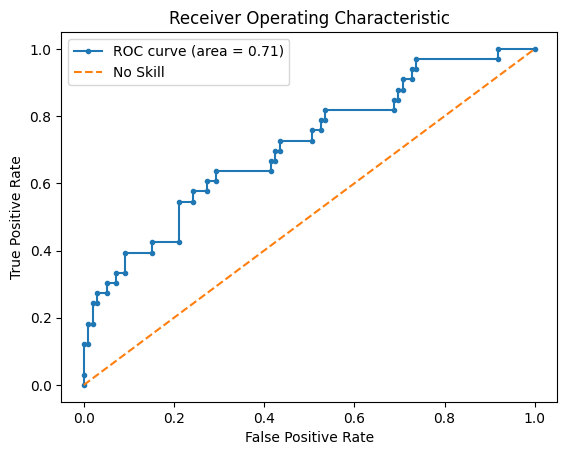

In [38]:
evaluate_model(Xception_best_model, test_loader, device)

## AlexNet Model

In [42]:
# Initialize the AlexNet model with pre-trained weights
alexnet_model = alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)

# Modifying the classifier for binary classification
# AlexNet's classifier has 6 layers, with the last one being the output layer.
num_ftrs = alexnet_model.classifier[6].in_features
alexnet_model.classifier[6] = nn.Linear(num_ftrs, 2)

# Define the device and move the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet_model = alexnet_model.to(device)

# Setup the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet_model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [43]:
AlexNet_best_model = train_model(alexnet_model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=30, patience=5)

Epoch 1/30
Train Loss: 0.5883 Acc: 0.7277
Validation Loss: 0.6135 Acc: 0.6870
Validation loss decreased, saving model...
Epoch 2/30
Train Loss: 0.5208 Acc: 0.7506
Validation Loss: 0.5490 Acc: 0.7557
Validation loss decreased, saving model...
Epoch 3/30
Train Loss: 0.4739 Acc: 0.7735
Validation Loss: 0.5654 Acc: 0.7099
Validation loss did not decrease, epochs with no improvement: 1.
Epoch 4/30
Train Loss: 0.4335 Acc: 0.7939
Validation Loss: 0.5664 Acc: 0.7252
Validation loss did not decrease, epochs with no improvement: 2.
Epoch 5/30
Train Loss: 0.4318 Acc: 0.8015
Validation Loss: 0.6054 Acc: 0.7481
Validation loss did not decrease, epochs with no improvement: 3.
Epoch 6/30
Train Loss: 0.4363 Acc: 0.7888
Validation Loss: 0.5183 Acc: 0.7786
Validation loss decreased, saving model...
Epoch 7/30
Train Loss: 0.3687 Acc: 0.8422
Validation Loss: 0.6737 Acc: 0.6870
Validation loss did not decrease, epochs with no improvement: 1.
Epoch 8/30
Train Loss: 0.3404 Acc: 0.8524
Validation Loss: 0.5505

Accuracy: 0.7803
Precision: 0.8333
Recall: 0.1515
F1 Score: 0.2564
ROC AUC Score: 0.6780
Confusion Matrix:
 [[98  1]
 [28  5]]


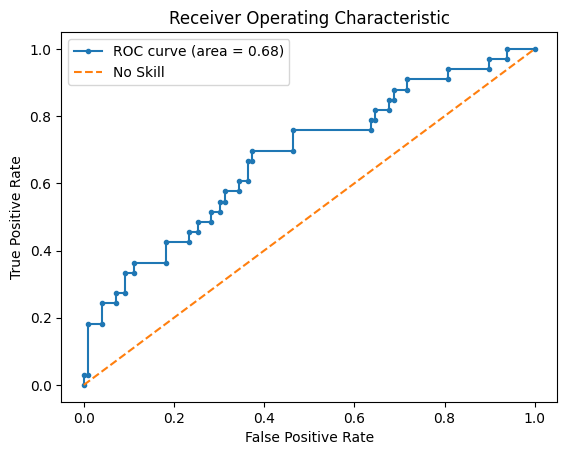

In [44]:
evaluate_model(AlexNet_best_model, test_loader, device)

#### Checking results

In [45]:
def imshow(inp, ax, title=None):
    """Imshow for Tensor on a given axes object."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)
    if title is not None:
        ax.set_title(title)
    ax.axis('off')

def display_images_with_confidence(model, data_loader, class_names, num_images=4):
    model.eval()  # Set model to evaluation mode
    images_handled = 0
    
    # Calculate the number of rows and columns for the subplots
    num_rows = 1
    num_cols = num_images
    
    # Set up the subplot grid
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3))
    if num_images == 1:
        axes = [axes]
    
    with torch.no_grad():  # Inference without gradient calculation
        for images, labels in data_loader:
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)
            confidences, preds = torch.max(probabilities, 1)
            
            # Move images, labels, and confidences to CPU
            images = images.cpu()
            labels = labels.cpu()
            preds = preds.cpu()
            confidences = confidences.cpu()
            
            for i in range(images.size()[0]):
                if images_handled >= num_images:
                    plt.tight_layout()
                    plt.show()
                    return
                
                ax = axes[images_handled]
                confidence_pct = confidences[i].item() * 100
                imshow(images[i], ax, title=f'Predicted: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}\nConfidence: {confidence_pct:.2f}%')
                
                images_handled += 1

    plt.tight_layout()
    plt.show()

### Now we can visualize the accuracy for images with the class of skin leason

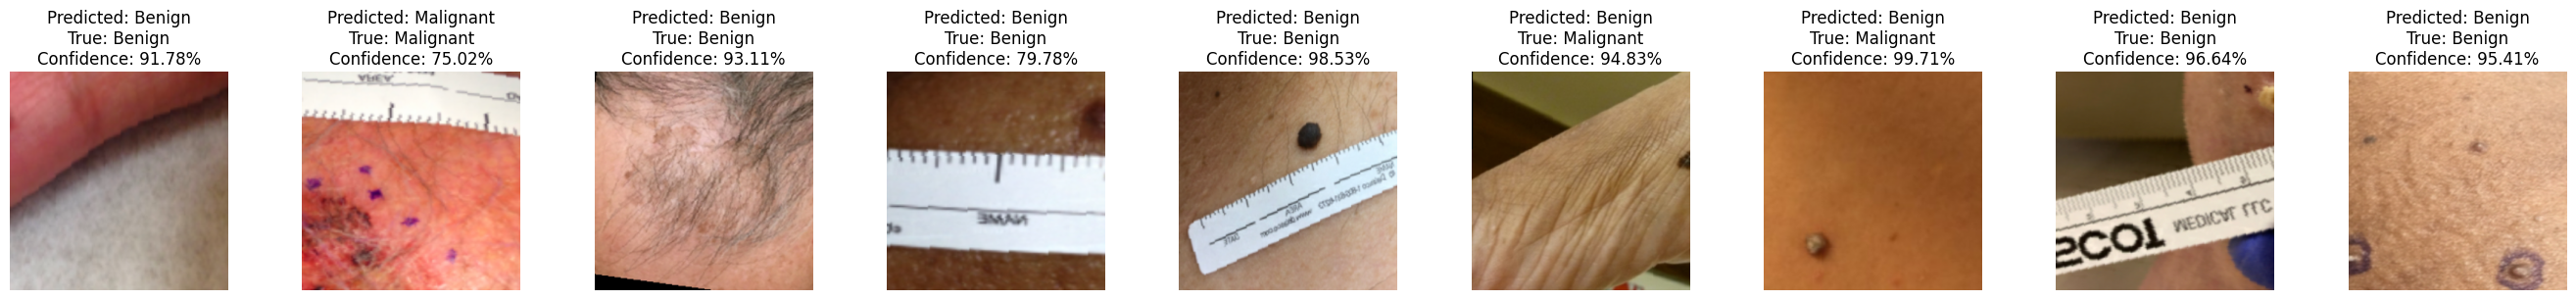

In [46]:
class_names = ['Benign', 'Malignant']
display_images_with_confidence(ResNet50_best_model, test_loader, class_names, num_images=9)   ### Chose the required model